# Predicting the Appeal of Pet Photos #

This notebook, developed for a Kaggle competition, seeks to predict the popularity -- or "Pawpularity" -- of photos posted to an online pet rescue site. Pawpularity scores are based on viewer interest in the images, normalized for such factors as position on a web page and geographic locale. The broader aim of the Kaggle competition was to gain insight into improving the appeal of pet photos -- and to find more homes for rescue pets.     

Below is an exploration of the images and related meta data as well as a number of machine learning models, including basic regression, gradient-boosted decision trees, neural networks and various ensembles.

Scoring of the models was based on the root mean squared error (RMSE) of predicted scores versus actual scores. In the end, a pre-trained neural network, using images but not their associated meta data, scored the highest of the models considered in this notebook.

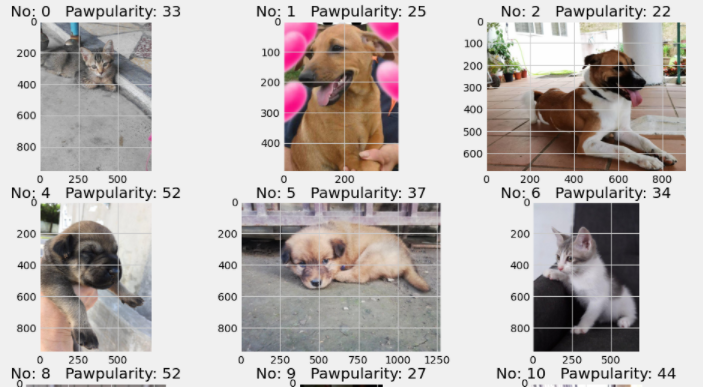


## Imports, Data Load and Helper Functions ##

In [ ]:
import os
import random
import gc
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from time import time
from tqdm import tqdm_notebook
import cv2
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression

import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Tabular data file paths
TRAIN_DATA_PATH = '../input/petfinder-pawpularity-score/train.csv'
TEST_DATA_PATH = '../input/petfinder-pawpularity-score/test.csv'

# Image data directories
TRAIN_DIRECTORY = '../input/petfinder-pawpularity-score/train'
TEST_DIRECTORY = '../input/petfinder-pawpularity-score/test'

In [ ]:
# Parameters for processing tabular data
TARGET_NAME = 'Pawpularity'
VAL_SIZE = 0.15
SEED = 42

In [ ]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 224  #also 299, depending on model
BATCH_SIZE = 32
DROPOUT_RATE = 0.2
LEARNING_RATE = 1e-3
DECAY_STEPS = 100
DECAY_RATE = 0.96
EPOCHS = 25
PATIENCE = 4

# To gradually decrease learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    staircase=True)

# To monitor validation loss and stop the training.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=PATIENCE,
                                              restore_best_weights=True)

# Pretrained image classification models
IMG_MODEL = '../input/keras-applications-models/EfficientNetB0.h5'  # 224 image size
# IMG_MODEL = '../input/keras-applications-models/EfficientNetB4.h5' # 299 image size

In [ ]:
class StopExecution(Exception):
    """Stops current and subsequent cells quietly"""
    def _render_traceback_(self):
        pass


def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


def set_display():
    """Sets display options for charts and pd.DataFrames.   
    param: None  
    return: None
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format


def id_to_path(img_id, dir):
    """Returns a path to an image file.
    :param img_id: Image Id
    :param dir: Path to the directory with images
    :return: Image file path
    """
    return os.path.join(dir, f'{img_id}.jpg')


def preprocess(image_url):
    """Loads image from a file and preprocesses it.
    :param image_url: Path to image file
    :return: Tensor with preprocessed image
    """
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE),
                    dtype=tf.int32)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image


@tf.function
def get_image(path):
    """Loads image from a file and preprocesses it.
    :param path: Path to image file
    :return: Tensor with preprocessed image
    """
    image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE),
                    dtype=tf.int32)
    return tf.keras.applications.efficientnet.preprocess_input(image)


@tf.function
def process_dataset(path, label):
    """Returns preprocessed image and label.
    :param path: Path to image file
    :param label: Class label
    :return: tf.Tensor with preprocessed image, numeric label
    """
    return get_image(path), label


@tf.function
def get_dataset(x, y=None):
    """Creates batched optimized dataset for the model
    out of an array of file paths and (optionally) class labels.
    :param x: Input data for the model (array of file paths)
    :param y: Target values for the model (array of class indexes)
    :return: TensorFlow Dataset object
    """
    if y is not None:
        ds = tf.data.Dataset.from_tensor_slices((x, y))
        return ds.map(process_dataset, num_parallel_calls=AUTOTUNE) \
            .batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices(x)
        return ds.map(get_image, num_parallel_calls=AUTOTUNE) \
            .batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


def plot_history(hist):
    """Plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    # Losses and metrics
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    rmse = hist.history['root_mean_squared_error']
    val_rmse = hist.history['val_root_mean_squared_error']

    # Epochs to plot along x axis
    x_axis = range(1, len(loss) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    ax1.plot(x_axis, loss, 'bo', label='Training')
    ax1.plot(x_axis, val_loss, 'ro', label='Validation')
    ax1.set_title('MSE Loss')
    ax1.legend()

    ax2.plot(x_axis, rmse, 'bo', label='Training')
    ax2.plot(x_axis, val_rmse, 'ro', label='Validation')
    ax2.set_title('Root Mean Squared Error')
    ax2.set_xlabel('Epochs')
    ax2.legend()

    plt.tight_layout()
    plt.show()


def get_image_model():
    """Loads pre-trained image classification model and adds additional layers
    param: None
    returns: Tensorflow model
    """

    # Pretrained image classification model
    feature_model = tf.keras.models.load_model(IMG_MODEL)

    # Freeze weights in the original model
    feature_model.trainable = False

    # This model takes in 224 x 224 images, applies random horizontal flip and rotation
    # (only in the train mode), passes image arrays through pretrained
    # feature extraction model and applies augmentation, batch normalization, dropout
    # and activations to get the target score.
    img_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode='horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.15),
        feature_model,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(DROPOUT_RATE, name='top_dropout'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, name='score')
    ])

    return img_model


def get_multi_model():
    """Loads pre-trained image classification model, joins it with
    a model focused on tabular data, and adds additional layers
    param: None
    returns: Tensorflow model
    """

    # Pretrained image classification model
    feature_model = tf.keras.models.load_model(IMG_MODEL)

    # Freeze(False)/Unfreeze (True) weights in the original model
    feature_model.trainable = False

    # image inputs
    image_inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x_image = tf.keras.layers.experimental.preprocessing.RandomFlip(
        mode='horizontal')(image_inputs)
    x_image = feature_model(x_image)
    x_image = tf.keras.layers.BatchNormalization()(x_image)
    x_image = tf.keras.layers.Dropout(DROPOUT_RATE,
                                      name='top_dropout')(x_image)
    x_image = tf.keras.layers.Dense(32, activation='relu')(x_image)

    # meta data inputs
    meta_inputs = tf.keras.Input(shape=((12, )))
    x_meta = tf.keras.layers.Dense(12, activation='relu')(meta_inputs)

    # Concatenate inputs and adds final layers
    x = tf.keras.layers.Concatenate(axis=1)([x_image, x_meta])
    x = tf.keras.layers.Dense(4, activation="relu")(x)  ## ADDED
    output = tf.keras.layers.Dense(1, name='score')(x)
    model = tf.keras.Model(inputs=[image_inputs, meta_inputs], outputs=output)

    return model


def get_image_model_rev():
    """Loads pre-trained image classification model and adds additional layers
    param: None
    returns: Tensorflow model
    """

    # Pretrained image classification model
    feature_model = tf.keras.models.load_model(IMG_MODEL)

    # Freeze weights in the original model
    feature_model.trainable = False

    #  Unfreeze n blocks
    for layer in feature_model.layers[221:]:  #221
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # This model takes in 224 x 224 images, applies random augmentations
    # (only in the train mode), passes image arrays through pretrained
    # feature extraction model and applies batch normalization, dropout
    # and activations to get the target score.
    img_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode='horizontal', seed=SEED),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.15,
                                                                  seed=SEED),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(
            height_factor=0.1, width_factor=0.1, seed=SEED),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1,
                                                                  seed=SEED),
        feature_model,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(DROPOUT_RATE, name='top_dropout'),
        tf.keras.layers.Dense(12, activation='relu'),  # 12 best 
        tf.keras.layers.Dense(1, name='score')
    ])

    return img_model


def preprocess2(image_url, tabular_data, y_value):
    """Preprocesses data for a multi-input TensorFlow model (
    image and tabular data, and target value) 
    :param image_url: Path to image file
    :param tabular_data: Meta data associated with each image
    :return: Tuple with image, associated meta data, and target value
    """
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE),
                    dtype=tf.int32)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    label = y_value
    return (image, tabular_data), label

## Data Processing ##

In [ ]:
set_seed(SEED)
set_display()

In [ ]:
# Train data set
data_train_master = pd.read_csv(TRAIN_DATA_PATH)
data_train = data_train_master.copy()
print(f'Train data shape: {data_train.shape}')
data_train.head()

In [ ]:
# Test data set
data_test_master = pd.read_csv(TEST_DATA_PATH)
data_test=data_test_master.copy()
print(f'Test data shape: {data_test.shape}')
data_test.head()

In [ ]:
# Make list of tabular columns
tabular_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 
                   'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

# Reconstruct the paths to train and test images.
data_train['path'] = data_train['Id'].apply(
    lambda x: id_to_path(x, TRAIN_DIRECTORY))
data_test['path'] = data_test['Id'].apply(
    lambda x: id_to_path(x, TEST_DIRECTORY))

# Keep a portion of the labeled data for validation.
split = train_test_split(
    data_train[['path', TARGET_NAME]], data_train[tabular_columns],
    test_size=VAL_SIZE, shuffle=True, random_state=SEED
)
(train_subset_images, valid_subset_images, train_subset_attr, valid_subset_attr) = split


## Exploratory Data Analysis ##

### View sample images ###

In [ ]:
sample_images=train_subset_images.sample(50)

plt.figure(figsize=(20, 20))
row, col = 5, 4
for i in range(row * col):
    plt.subplot(row, col, i+1)
    image = cv2.imread(sample_images['path'].iloc[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = sample_images['Pawpularity'].iloc[i]
    plt.imshow(image)
    plt.title(f"No: {i}" f"   Pawpularity: {target}")
plt.show()

### Photo meta data ###

Each pet photo is labeled with a value of 1 (Yes) or 0 (No) for each of the following features:

**Focus** - Pet stands out against uncluttered background, not too close / far.  
**Eyes** - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.  
**Face** - Decently clear face, facing front or near-front.  
**Near** - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).  
**Action** - Pet in the middle of an action (e.g., jumping).  
**Accessory** - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.  
**Group** - More than 1 pet in the photo.  
**Collage** - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).  
Human - Human in the photo.  
**Occlusion** - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.  
**Info** - Custom-added text or labels (i.e. pet name, description).  
**Blur** - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0.    



The meta data is unusually clean -- at least superficially.  There are no missing values.  But the predictive value of the meta data appears to be very limited. 

In [ ]:
# Value counts and data types 
data_train.info()

In [ ]:
# Summary stats 
data_train.describe()

In [ ]:
# No missing values for any of the features 
data_train.isna().sum()

In [ ]:
# Binary counts by feature (1 = Yes, 0 = No)
result = data_train[tabular_columns].apply(pd.value_counts) 
result

Pawpularity scores range from 1-100, with a mean score of 38.0

In [ ]:
# Summary stats of target value
data_train["Pawpularity"].describe()

In [ ]:
# Histogram of target value
data_train["Pawpularity"].plot.hist()

Correlations were strongest between the following pairs: Occlusion/Human (human image blocking some of pet),  Face/Eyes (both reasonably seen) and Info/Collage (indicating image manipulation by the submitter). There is little to no correlation between the various features and Pawpularity score, suggesting that the tabular features will yield little predictive value.

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
corr = data_train.drop(['Id', 'path'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap=sns.heatmap(corr, cmap="Blues", mask=mask, annot=True,  fmt=".2f")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

## Models ##

For baseline reference, a model that simply predicts the mean Pawpularity score on the train data (i.e., 38) yields an RMSE of about 20.5 on the unseen test data.   

### Linear Regression ###

A simple linear regression model, using only the tabular data, yields an RMSE just about the same as using the mean Pawpularity score (of 38) for all predictions, suggesting little or no predictive value from the meta data. 

In [ ]:
X = data_train[tabular_columns]
y = data_train["Pawpularity"]

X_train, X_valid,y_train,y_valid = train_test_split(X,y,test_size =0.2)

linreg = LinearRegression()
model = linreg.fit(X_train, y_train)

y_pred=model.predict(X_valid)

In [ ]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print("Linear Regression RMSE: ", np.around(np.sqrt(metrics.mean_squared_error(y_valid, y_pred)),2))

### lightGBM ###

lightGBM, typically more powerful than a linear regression model, yields a slightly better RMSE on the meta data -- about 20.3.

In [ ]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state = 889)

quick = False
if quick:
    lr = 0.1
    Early_Stopping_Rounds = 150
else:
    lr = 0.01
    Early_Stopping_Rounds = 300

N_round = 6000
Verbose = 100
params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            'learning_rate': lr, 
            'num_leaves': 2 ** 3,
            'bagging_fraction': 0.95,
            'bagging_freq': 1,
            'bagging_seed': 66,
            'feature_fraction': 0.7,
            'feature_fraction_seed': 66,
            'max_bin': 100,
            'max_depth': 5
        }

In [ ]:
lgb_sub = data_test
lgb_sub["Pawpularity"] = 0

RMSEs = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = data_train[tabular_columns].columns

N_MODEL = 1.0
for model_i in tqdm_notebook(range(int(N_MODEL))):

    if N_MODEL != 1.0:
        params['seed'] = model_i + 1123

    for fold_n, (train_index, valid_index) in enumerate(folds.split(data_train[tabular_columns])):

        start_time = time()
        print('Training on model {} - fold {}'.format(model_i + 1, fold_n + 1))
        
        trn_data = lgb.Dataset(data_train[tabular_columns].iloc[train_index], label=data_train["Pawpularity"].iloc[train_index], categorical_feature="")
        val_data = lgb.Dataset(data_train[tabular_columns].iloc[valid_index], label=data_train["Pawpularity"].iloc[valid_index], categorical_feature="")
        lgb_model = lgb.train(params, trn_data, num_boost_round=N_round, valid_sets=[trn_data, val_data], verbose_eval=Verbose,
                        early_stopping_rounds=Early_Stopping_Rounds)  # , feval=evalerror
        
        # dump model with pickle
        with open(f'model_{model_i}_fold_{fold_n}.pkl', 'wb') as fout:
            pickle.dump(lgb_model, fout)

        feature_importances['model_{}-fold_{}'.format(model_i + 1, fold_n + 1)] = lgb_model.feature_importance()
        
        val = lgb_model.predict(data_train[tabular_columns].iloc[valid_index])
        pred = lgb_model.predict(data_test[tabular_columns])
        lgb_sub["Pawpularity"] = lgb_sub["Pawpularity"] + pred / n_fold / N_MODEL
        
        score = lgb_model.best_score['valid_1']['rmse']
        RMSEs.append(score)
        
        print("Best valid RMSE: ", score)
        print("Best iteration: ", lgb_model.best_iteration)
        print('Model {} - Fold {} finished in {}'.format(model_i + 1, fold_n + 1,
                                                         str(datetime.timedelta(seconds=time() - start_time))))
print("done!")
print("***" * 50)
print("Best valid RMSE: ", min(RMSEs))

The top three features in terms of predictive value are Near (pet image is large relative to picture size), Group (multiple images of a pet in one photo), and Info (pet name and other text added to photo).  

In [ ]:
feature_importances['average'] = feature_importances[[x for x in feature_importances.columns if x != "feature"]].mean(axis=1)
feature_importances = feature_importances.sort_values(by = "average", ascending = False)
feature_importances

In [ ]:
lgb_sub

In [ ]:
# For blending purposes (see blending model below)
lgb_preds = lgb_model.predict(data_train[tabular_columns],num_iteration=lgb_model.best_iteration, verbose=1) # best iteration of last fold 
lgb_preds

In [ ]:
## To submit....
# lgb_sub=lgb_sub[["Id", "Pawpularity"]].copy()
# lgb_sub.to_csv("lgb_submission.csv", index=False, header = True)

### Neural Network Models ###

In [ ]:
# Prepare data for Tensorflow formats
x_path = train_subset_images['path']
x_val = valid_subset_images['path']

tabular_train = train_subset_attr.values
tabular_val = valid_subset_attr.values

y_train =  train_subset_images['Pawpularity']
y_val = valid_subset_images['Pawpularity']

#### Image-only Model ####

In [ ]:
# Create TensorFlow datasets
train_image_ds = get_dataset(x=x_path, y=y_train)
valid_image_ds = get_dataset(x=x_val, y=y_val)
test_image_ds = get_dataset(x=data_test['path'], y=None)

In [ ]:
nn_model = get_image_model()

In [ ]:
tf.keras.utils.plot_model(nn_model, show_shapes=True)

In [ ]:
nn_model.summary()

In [ ]:
# Compile the model
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = nn_model.fit(train_image_ds, validation_data=valid_image_ds,
                          epochs=EPOCHS, callbacks=[early_stop],
                          use_multiprocessing=True, workers=-1)

In [ ]:
plot_history(history)

In [ ]:
best_score = min(history.history['val_root_mean_squared_error'])
print(f'Best RMSE score on validation dataset is: {best_score:.2f}')

Train on full training dataset 

In [ ]:
combined_ds = train_image_ds.concatenate(valid_image_ds)

In [ ]:
history = nn_model.fit(combined_ds, epochs=EPOCHS, use_multiprocessing=True, workers=-1)

In [ ]:
# # Predict popularity score for the test and submit to competition
data_test[TARGET_NAME] = nn_model.predict(
    test_image_ds, use_multiprocessing=True, workers=os.cpu_count())
# data_test[['Id', TARGET_NAME]].to_csv('submission.csv', index=False) # Will only submit final, best model-- see very end of notebook
data_test[['Id', TARGET_NAME]].head()

In [ ]:
# For blending purposes (see blending model below)
nn_preds=nn_model.predict(
    combined_ds, use_multiprocessing=True, workers=os.cpu_count())
nn_preds = nn_preds.flatten()
nn_preds

In [ ]:
gc.collect()

#### Multi-input NN #####

Combines image and tabular features in a NN 

In [ ]:
model2 = get_multi_model()

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [ ]:
x_path = train_subset_images['path']
x_val = valid_subset_images['path']

tabular_train = train_subset_attr.values
tabular_val = valid_subset_attr.values

y_train =  train_subset_images['Pawpularity']
y_val = valid_subset_images['Pawpularity']

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_path,tabular_train, y_train)).map(preprocess2).batch(BATCH_SIZE).cache().prefetch(2)
val_ds = tf.data.Dataset.from_tensor_slices(
    (x_val,tabular_val, y_val)).map(preprocess2).batch(BATCH_SIZE).cache().prefetch(2)

In [ ]:
# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history = model2.fit(train_ds, validation_data=val_ds,
                          epochs=EPOCHS, callbacks=[early_stop],
                          use_multiprocessing=True, workers=-1)

In [ ]:
plot_history(history)


In [ ]:
best_score = min(history.history['val_root_mean_squared_error'])
print(f'Best RMSE score on validation dataset is: {best_score:.2f}')

## Ensembles ##

An ensemble model of lightGBM (on the meta data) and the neural network (image only) did not improve on the stand-alone neural network model.

In [ ]:
# Process data 
y = data_train["Pawpularity"]
blended_df= pd.DataFrame({'lgb_preds': lgb_preds, 'nn_preds': nn_preds, 'y': y})
blended_df.head()

In [ ]:
X = blended_df[['lgb_preds', 'nn_preds']]

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size =0.2)

linreg = LinearRegression()
model = linreg.fit(X_train, y_train)

y_pred=model.predict(X_test)

In [ ]:
print("Linear Regression RMSE: ", np.around(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

### Image-only NN tuning ###

In [ ]:
# Data preprocessing to feed Tensorflow models
x_path = train_subset_images['path']
x_val = valid_subset_images['path']

y_train =  train_subset_images['Pawpularity']
y_val = valid_subset_images['Pawpularity']

In [ ]:
# Create TensorFlow datasets
train_image_ds = get_dataset(x=x_path, y=y_train)
valid_image_ds = get_dataset(x=x_val, y=y_val)
test_image_ds = get_dataset(x=data_test['path'], y=None)

In [ ]:
nn_model = get_image_model_rev()

In [ ]:
tf.keras.utils.plot_model(nn_model, show_shapes=True)

In [ ]:
nn_model.summary()

In [ ]:
# EPOCHS = 60
# Compile the model
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = nn_model.fit(train_image_ds, validation_data=valid_image_ds,
                          epochs=EPOCHS, callbacks=[early_stop],
                          use_multiprocessing=True, workers=-1)

In [ ]:
plot_history(history)

In [ ]:
# dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])
best_score = min(history.history['val_root_mean_squared_error'])
print(f'Best RMSE score on validation dataset is: {best_score:.2f}')

#### Re-train on full training dataset ###
Provided slight boost to re-train on full set. 

In [ ]:
combined_ds = train_image_ds.concatenate(valid_image_ds)

In [ ]:
history = nn_model.fit(combined_ds, epochs=EPOCHS, use_multiprocessing=True, workers=-1)

In [ ]:
# Predict popularity score for the test
data_test[TARGET_NAME] = nn_model.predict(
    test_image_ds, use_multiprocessing=True, workers=os.cpu_count())
# data_test[['Id', TARGET_NAME]].to_csv('submission.csv', index=False)  # Only submit final model, see below 
data_test[['Id', TARGET_NAME]].head()

In [ ]:
gc.collect()

### Final model: Stratified k-fold image only ###
An ensemble model that averages predictions made from best-scoring models within cross-validation folds yielded the highest score on the competition's hold out test set. 

In [ ]:
x_path = data_train['path']
y_train =  data_train['Pawpularity']

# Create TensorFlow datasets
train_image_ds = get_dataset(x=x_path, y=y_train)
test_image_ds = get_dataset(x=data_test['path'], y=None)

In [ ]:
test_final_preds = []  
num_epochs_avg = [] 
kfold_splits = 5
fold_no = 1


# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

# Loop through the indices the split() method returns
for fold, (train_idx, val_idx) in enumerate(skf.split(data_train['path'], data_train['Pawpularity'])):
                                            
  train_ds = get_dataset(data_train['path'].loc[train_idx], y=data_train['Pawpularity'].loc[train_idx])
  val_ds = get_dataset(data_train['path'].loc[val_idx], y=data_train['Pawpularity'].loc[val_idx])

  model = None
  model = get_image_model_rev()

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

  # Generate a print
  print('--' *  50)
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(train_ds, validation_data=val_ds,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[early_stop],
                          use_multiprocessing=True, workers=-1)

  # fit best model on complete training dataset 
  print("_______________Fitting on combined data _____________________")
  model.fit(combined_ds, epochs=15, use_multiprocessing=True, workers=-1)  


  # make predictions on TEST set 
  yhat = model.predict(test_image_ds)  
  test_final_preds.append(yhat)
    
  n_epochs = len(history.history['val_root_mean_squared_error'])
  num_epochs_avg.append(n_epochs)

  # Generate generalization metrics
  best_score = min(history.history['val_root_mean_squared_error'])
  print(f'Best RMSE score on validation dataset is: {best_score:.2f}')
  # Increase fold number
  fold_no = fold_no + 1

In [ ]:
optimal_epochs = np.mean(num_epochs_avg) - PATIENCE
print(f"Best RMSE by epoch: {num_epochs_avg}")
print(f"Avg number of optimal epochs: {optimal_epochs}")

In [ ]:
# Average the predictions across the models in each fold
test_final_preds_avg = np.mean(np.column_stack(test_final_preds), axis=1)

# Predict popularity score for the test
data_test[TARGET_NAME] = test_final_preds_avg
data_test[['Id', TARGET_NAME]].to_csv('submission.csv', index=False)
data_test[['Id', TARGET_NAME]].head()

In [ ]:
# # STOP EXECUTION _______________________________________________________________________________________
# print("________________StopExecution____________________________")
# raise StopExecution